In [2]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [204]:
import math
import os
import time


import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product
import copy


from tqdm import tqdm

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip

from scipy.stats import entropy
from pympler import asizeof

from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily,\
      CountMinSketchHadamard, CountMinSketchLocalHashing, deterministic_hash, simple_deterministic_hash, \
      fast_hash_xx
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes
from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange, \
      minimal_b_adic_cover_array, downgrade_b_adic_range_indices
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters, \
      cartesian_product, get_n_updates, MaterializedCombinations

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, filter_df, query_df, \
      infer_domains_and_ranges, translate_query_region, evaluate_queries, check_accruracy, \
      evaluate_queries_baselines, evaluate_equivalent_pacha_sketches, compute_relative_entropy

# set_style()

In [168]:
(240 * 1024) // (150 * 1024)

1

# Different Datasets

## Retail

In [ ]:
retail_df = pd.read_parquet("../data/clean/online_retail.parquet")
query_path = "../queries/retail/online_retail_random.json"
with open(query_path, 'rb') as f:
    retail_queries_rand = orjson.loads(f.read())

retail_ad_tree = ADTree.from_json("../sketches/ad_trees/online_retail.json")

In [ ]:
retail_p_sketch = PachaSketch.from_json("../sketches/retail/retail_p0.01_eps0.0005.json")

In [10]:
retail_results_rand = evaluate_queries(retail_df, retail_queries_rand["queries"], retail_p_sketch, path_to_file="../results/accuracy/retail_rand_p_sketch.csv")

Computing true counts...


True Count: 100%|██████████| 500/500 [00:12<00:00, 39.89it/s]


Computing estimates...


Estimates: 100%|██████████| 500/500 [00:20<00:00, 24.79it/s]


In [11]:
retail_results_rand[['absolute_error', 'normalized_error', 'relative_error']].describe()

,absolute_error,normalized_error,relative_error
count,500.000000,500.000000,500.000000
mean,250.244000,0.000462,0.087994
std,815.691799,0.001505,0.321107
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000002,0.000008
75%,56.000000,0.000103,0.024908
max,10015.000000,0.018481,5.000000


## Bank

In [28]:
bank_df = pd.read_parquet("../data/clean/bank_marketing.parquet")
query_path = "../queries/bank/bank_random.json"
with open(query_path, 'rb') as f:
    bank_queries_rand = orjson.loads(f.read())

query_path = "../queries/bank_marketing_2_cols.json"
with open(query_path, 'rb') as f:
    bank_queries_2_cols = orjson.loads(f.read())

bank_ad_tree = ADTree.from_json("../sketches/ad_trees/bank_marketing.json")

In [10]:
bank_p_sketch = PachaSketch.from_json("../sketches/bank/bank_p0.01_eps0.0005.json")

In [21]:
bank_p_sketch_big = PachaSketch.from_json("../sketches/bank/bank_p0.005_eps0.00025.json")

In [15]:
bank_results_rand = evaluate_queries(bank_df, bank_queries_rand["queries"], bank_p_sketch, path_to_file="../results/accuracy/bank_rand_p_sketch.csv")

Computing true counts...


True Count: 100%|██████████| 500/500 [00:01<00:00, 444.71it/s]


Computing estimates...


Estimates: 100%|██████████| 500/500 [03:16<00:00,  2.54it/s]


In [32]:
bank_results_rand_big = evaluate_queries(bank_df, bank_queries_2_cols["queries"][:100], bank_p_sketch)

Computing true counts...


True Count: 100%|██████████| 100/100 [00:00<00:00, 439.03it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [00:00<00:00, 1312.35it/s]


In [33]:
bank_results_rand_big[['absolute_error', 'normalized_error', 'relative_error']].describe()

,absolute_error,normalized_error,relative_error
count,100.000000,100.000000,100.0
mean,5127.600000,0.113415,1.0
std,3692.989036,0.081683,0.0
min,69.000000,0.001526,1.0
25%,1893.250000,0.041876,1.0
50%,4247.000000,0.093937,1.0
75%,8508.500000,0.188195,1.0
max,12833.000000,0.283847,1.0


In [31]:
bank_results_rand_big

,runtimes,true_counts,estimates,relevant_nodes,cat_regions,b_adic_cubes,num_regions,candidate_regions,query_regions,level_0_queries,level_1_queries,level_2_queries,level_3_queries,level_4_queries,level_5_queries,absolute_error,normalized_error,relative_error,total_sketch_queries
0,0.001190,12241,0.0,1,1,11,0,0,0,0,0,0,0,0,0,12241.0,0.270753,1.0,12
1,0.000556,11344,0.0,1,1,7,0,0,0,0,0,0,0,0,0,11344.0,0.250912,1.0,8
2,0.000931,7620,0.0,48,48,7,0,0,0,0,0,0,0,0,0,7620.0,0.168543,1.0,55
3,0.002183,3001,0.0,192,178,19,0,0,0,0,0,0,0,0,0,3001.0,0.066378,1.0,211
4,0.001035,10344,0.0,1,1,15,0,0,0,0,0,0,0,0,0,10344.0,0.228794,1.0,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000815,6418,0.0,1,1,16,0,0,0,0,0,0,0,0,0,6418.0,0.141957,1.0,17
96,0.000468,1675,0.0,4,4,4,0,0,0,0,0,0,0,0,0,1675.0,0.037049,1.0,8
97,0.001096,8602,0.0,1,1,7,0,0,0,0,0,0,0,0,0,8602.0,0.190263,1.0,8
98,0.000599,1043,0.0,4,4,10,0,0,0,0,0,0,0,0,0,1043.0,0.023070,1.0,14


In [16]:
bank_results_rand[['absolute_error', 'normalized_error', 'relative_error']].describe()

,absolute_error,normalized_error,relative_error
count,500.000000,500.000000,500.000000
mean,1657.958000,0.036672,0.549317
std,3611.460402,0.079880,0.469477
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,42.500000,0.000940,0.893872
75%,686.000000,0.015173,1.000000
max,15747.000000,0.348300,1.000000


In [20]:
compute_relative_entropy(bank_results_rand)

3.4211743207243894

## Census

In [34]:
census_df = pd.read_parquet("../data/clean/acs_folktables.parquet")
query_path = "../queries/census/census_random.json"
with open(query_path, 'rb') as f:
    census_queries_rand = orjson.loads(f.read())
census_ad_tree = ADTree.from_json("../sketches/ad_trees/acs_folktables.json")

In [35]:
census_p_sketch = PachaSketch.from_json("../sketches/census/census_p0.01_eps0.0005.json")

In [40]:
census_results_rand = evaluate_queries(census_df, census_queries_rand["queries"], census_p_sketch, path_to_file="../results/accuracy/census_rand_p_sketch.csv")

Computing true counts...


True Count: 100%|██████████| 500/500 [00:07<00:00, 71.26it/s]


Computing estimates...


Estimates: 100%|██████████| 500/500 [03:37<00:00,  2.30it/s]


In [41]:
census_results_rand[['absolute_error', 'normalized_error', 'relative_error']].describe()

,absolute_error,normalized_error,relative_error
count,500.000000,500.000000,500.000000
mean,5719.480000,0.015148,0.362624
std,15185.343836,0.040218,0.482742
min,0.000000,0.000000,0.000000
25%,8.000000,0.000021,0.000204
50%,105.000000,0.000278,0.041487
75%,2955.250000,0.007827,0.716415
max,104146.000000,0.275829,3.600000


In [43]:
compute_relative_entropy(census_results_rand)

0.29667248160203175

In [44]:
def plot_normalized_error_boxplot(dfs, palette=None):
    # Add 'approach' column if missing (assumes each df has a unique approach)
    for df in dfs:
        if 'approach' not in df.columns:
            raise ValueError("Each DataFrame must have an 'approach' column.")

    combined_df = pd.concat(dfs, ignore_index=True)
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='approach', y='normalized_error', hue='approach', data=combined_df, palette=palette)
    plt.xlabel('Approach')
    plt.ylabel('Normalized Error')
    plt.title('Comparison of Normalized Error by Approach')
    plt.grid(True)
    plt.tight_layout()
    plt.yscale('log')
    plt.xticks(rotation=-45)
    plt.show()


In [46]:
retail_results_rand = pd.read_csv("../results/accuracy/retail_rand_p_sketch.csv")

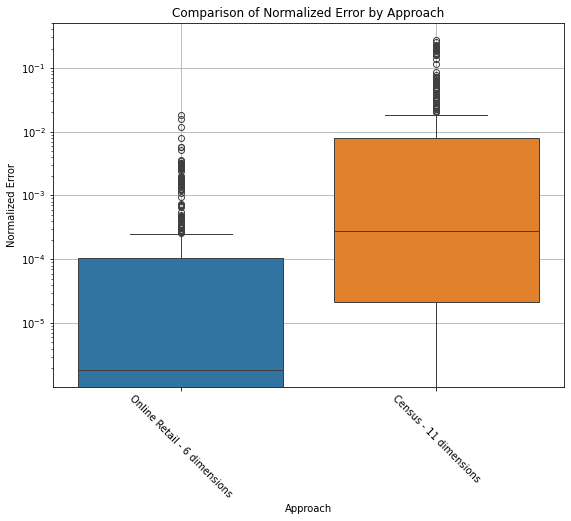

In [47]:
retail_results_rand['approach'] = 'Online Retail - 6 dimensions'
census_results_rand['approach'] = 'Census - 11 dimensions'

plot_normalized_error_boxplot([retail_results_rand, census_results_rand])

In [49]:
census_p_sketch.get_size()

384.5103816986084

In [ ]:


total_size = asizeof.asizeof(census_p_sketch)

print(f"Total size of census_p_sketch: {total_size / 1024/1024} MB")

Total size of census_p_sketch: 1792.0141830444336 MB


In [53]:
census_p_sketch.region_index.get_size()

148.41115188598633

In [54]:
asizeof.asizeof(census_p_sketch.region_index)/ 1024/1024

1187.2909927368164

## Lineitem

In [7]:
cat_cols = ['c_shipmode', 'c_returnflag', 'c_linestatus', 'c_discount', 'c_tax']
num_cols = ['n_shipdate', 'n_commitdate', 'n_receiptdate', 
            'n_extendedprice', 'n_quantity']

In [8]:
def get_n_updates_customized(ad_tree_levels, num_combinations, levels, debug=False):
    cat_index = ad_tree_levels
    num_index = num_combinations * levels + 1
    region_index = cat_index * num_index 
    base_sketches = region_index
    total = cat_index + num_index + region_index + base_sketches
    if debug:
        print("Nr. of updates in Pacha Sketch:")
        print(f"cat_index: {cat_index}")
        print(f"num_index: {num_index}")   
        print(f"region_index: {region_index}")
        print(f"base_sketches: {base_sketches}")
        print(f"Total: {total}")

    return cat_index, num_index, region_index

In [213]:
reload(pacha_sketch)
reload(sketches)
from lib.pacha_sketch import PachaSketch, ADTree

rel_eps = 0.0005
levels = 5
delta = 0.01
bloom_p = 0.01

cat_col_map_tpch = [0, 1, 2, 3, 4]
n_cat_tpch = len(cat_col_map_tpch)
num_col_map_tpch = [5, 6, 7, 8, 9]
n_num_tpch = len(num_col_map_tpch)
bases_tpch = [5,5,5,10,2]

ad_tree_levels = len(cat_cols)
num_combinations = 13
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels)

lineitem_df = pd.read_parquet("../data/tpch/lineitem_8.parquet")
len_df = len(lineitem_df)
# len_df = 5_000
tpch_ad_tree = ADTree.from_json("../sketches/ad_trees/tpch_lineitem.json")

error_eps = rel_eps / region_updates_tpch
tpch_p_sketch = PachaSketch.build_with_uniform_size(
    levels=levels,
    num_dimensions=n_cat_tpch + n_num_tpch,
    cat_col_map=cat_col_map_tpch,
    num_col_map=num_col_map_tpch,
    bases=bases_tpch,
    ad_tree=tpch_ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=error_eps),
    cat_index_parameters=BFParameters(n_values=len_df * cat_updates_tpch, p=bloom_p),
    num_index_parameters=BFParameters(n_values=len_df * num_updates_tpch, p=bloom_p),
    region_index_parameters=BFParameters(n_values=len_df * region_updates_tpch, p=bloom_p))

col_names = ['n_shipdate', 'n_commitdate', 'n_receiptdate', 'n_extendedprice', 'n_quantity']
relevant_combinations = [
    ['n_shipdate'],
    ['n_commitdate'],
    ['n_receiptdate'],
    ['n_extendedprice'],
    ['n_quantity'],
    
    ['n_shipdate', 'n_commitdate'],
    ['n_shipdate', 'n_receiptdate'],
    ['n_shipdate', 'n_quantity'],
    ['n_commitdate', 'n_receiptdate'],
    ['n_commitdate', 'n_extendedprice'],
    ['n_extendedprice', 'n_quantity'],
    
    ['n_commitdate', 'n_receiptdate', 'n_extendedprice'],
    
    ['n_shipdate', 'n_commitdate', 'n_receiptdate', 'n_extendedprice', 'n_quantity']
    ]

mat_combinations = MaterializedCombinations(col_names=col_names, relevant_combinations=relevant_combinations)
tpch_p_sketch.materialized = mat_combinations

: 

In [210]:
cat_updates_tpch, num_updates_tpch, region_updates_tpch = get_n_updates_customized(ad_tree_levels, num_combinations, levels, debug=True)

Nr. of updates in Pacha Sketch:
cat_index: 5
num_index: 66
region_index: 330
base_sketches: 330
Total: 731


In [211]:
731 * 500

365500

In [196]:
tpch_p_sketch.get_size()
print(f"Theoretical size: {tpch_p_sketch.get_size()}")
total_size = asizeof.asizeof(tpch_p_sketch)
print(f"Total size of tpch_p_sketch: {total_size / 1024/1024} MB")

Theoretical size: 173.48909664154053
Total size of tpch_p_sketch: 361.36195373535156 MB


In [162]:
query_path = "../queries/tpch/tpch_random.json"
with open(query_path, 'rb') as f:
    tpch_queries_rand = orjson.loads(f.read())

In [198]:
short_lineitem_df = lineitem_df.head(5_000)

In [184]:
len(lineitem_df)*16

47994736

In [187]:
len_df = 47_989_007
BFParameters(n_values=len_df * cat_updates_tpch, p=bloom_p).peek_size()

(2299887168, 7)

In [1]:
(47_989_007 /4 / 450)/ 60/60

7.405710956790123

In [175]:
(249973 / 450 )/ 60

9.25825925925926

In [205]:
tpch_p_sketch.update_data_frame(short_lineitem_df)

Updating: 100%|██████████| 5000/5000 [00:17<00:00, 277.91it/s]


In [206]:
results = evaluate_queries(short_lineitem_df, tpch_queries_rand['queries'], tpch_p_sketch)

Computing true counts...


True Count: 100%|██████████| 100/100 [00:00<00:00, 748.35it/s]


Computing estimates...


Estimates: 100%|██████████| 100/100 [00:02<00:00, 40.84it/s]


In [167]:
tpch_queries_rand['queries'][15]

['*', ['A'], '*', '*', '*', '*', [743, 1343], '*', [34881, 52436], '*']

In [208]:
results[results['normalized_error'] == results['normalized_error'].max()] 

,runtimes,true_counts,estimates,relevant_nodes,cat_regions,b_adic_cubes,num_regions,candidate_regions,query_regions,level_0_queries,level_1_queries,level_2_queries,level_3_queries,level_4_queries,absolute_error,normalized_error,relative_error,total_sketch_queries
81,0.057402,278,327.0,1,1,425,134,134,134,0,0,0,134,0,49.0,0.0098,0.176259,694


In [212]:
results['candidate_regions'] - results['query_regions']

0        0
1       69
2        1
3      107
4        4
      ... 
95       0
96    1128
97     232
98       2
99       0
Length: 100, dtype: int32

In [209]:
results['absolute_error'].describe()

count    100.000000
mean       2.400000
std        8.578809
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       49.000000
Name: absolute_error, dtype: float64

In [151]:
results['absolute_error'].describe()

count    100.000000
mean       0.710000
std        3.701747
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       27.000000
Name: absolute_error, dtype: float64